# Double Pendulum — Exploration of Initial Conditions (Julia)

Simulation implemented in `DoublePendulumModule` (Julia).  
Integrator: **fixed-step RK4** (dt = 0.005 s).  
The cell below runs `julia dp_sim.jl` to produce CSV files.  
> **Note:** Julia 1.10+ must be installed and on `PATH`.

**Equations of motion** (exact nonlinear Lagrangian, no small-angle approximation):

$$\Delta \equiv \theta_1 - \theta_2, \qquad D \equiv 2m_1 + m_2 - m_2\cos 2\Delta$$

$$\ddot{\theta}_1 = \frac{-g(2m_1+m_2)\sin\theta_1 - m_2 g\sin(\theta_1-2\theta_2) - 2\sin\Delta\cdot m_2\bigl(\dot\theta_2^2 L_2 + \dot\theta_1^2 L_1\cos\Delta\bigr)}{L_1\, D}$$

$$\ddot{\theta}_2 = \frac{2\sin\Delta\bigl(\dot\theta_1^2 L_1(m_1+m_2) + g(m_1+m_2)\cos\theta_1 + \dot\theta_2^2 L_2 m_2\cos\Delta\bigr)}{L_2\, D}$$

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams["figure.dpi"] = 110


In [2]:
def load(name):
    """Load a simulation CSV into a structured numpy array."""
    return np.genfromtxt(name, delimiter=",", names=True)


In [3]:
import subprocess, pathlib, sys

notebook_dir = pathlib.Path.cwd()
julia_dir    = notebook_dir.parent   # wClaudeCode/julia/

# Check for Julia
which = subprocess.run(["which", "julia"], capture_output=True, text=True)
if which.returncode != 0:
    print("Julia not found in PATH.")
    print("Install Julia 1.10+ from https://julialang.org/downloads/ and re-run.")
    print("Writing empty placeholder CSVs so downstream cells do not crash...")
    header = "t,theta1,omega1,theta2,omega2,x2,y2,energy\n"
    for name in [
        "case_nearlinear.csv", "case_intermediate.csv", "case_chaotic.csv",
        "sensitivity_a.csv", "sensitivity_b.csv",
        "mass_ratio_0.25.csv", "mass_ratio_1.00.csv", "mass_ratio_4.00.csv",
    ]:
        p = notebook_dir / name
        if not p.exists():
            p.write_text(header)
else:
    julia = which.stdout.strip()
    print(f"Julia found: {julia}")
    print("Running simulation...")
    r = subprocess.run(
        [julia, f"--project={julia_dir}", str(notebook_dir / "dp_sim.jl")],
        capture_output=True, text=True,
        cwd=str(notebook_dir),
    )
    print(r.stdout.strip() or "(no stdout)")
    if r.returncode != 0:
        print("Error:\n", r.stderr)
        sys.exit(1)


Julia not found in PATH.
Install Julia 1.10+ from https://julialang.org/downloads/ and re-run.
Writing empty placeholder CSVs so downstream cells do not crash...


## 1. Three regimes side-by-side

| Case | $\theta_1^0$ | $\theta_2^0$ | Expected behaviour |
|------|------------|------------|--------------------|  
| Near-linear | 10° | 10° | Quasi-periodic, both rods swing together |  
| Intermediate | 90° | 0° | Irregular but not fully chaotic |  
| Chaotic | 120° | −30° | Strongly chaotic, phase portrait fills region |

In [4]:
cases = [
    dict(label="Near-linear",  file="case_nearlinear.csv",   color="steelblue"),
    dict(label="Intermediate", file="case_intermediate.csv", color="seagreen"),
    dict(label="Chaotic",      file="case_chaotic.csv",      color="tomato"),
]

solutions = []
for c in cases:
    sol = load(c["file"])
    E0  = sol["energy"][0]
    dE  = np.max(np.abs(sol["energy"] - E0)) / abs(E0) * 100
    solutions.append(sol)
    print(f"{c['label']:15s}  E\u2080={E0:+.4f} J   max|\u0394E/E\u2080|={dE:.2e} %")


IndexError: index 0 is out of bounds for axis 0 with size 0

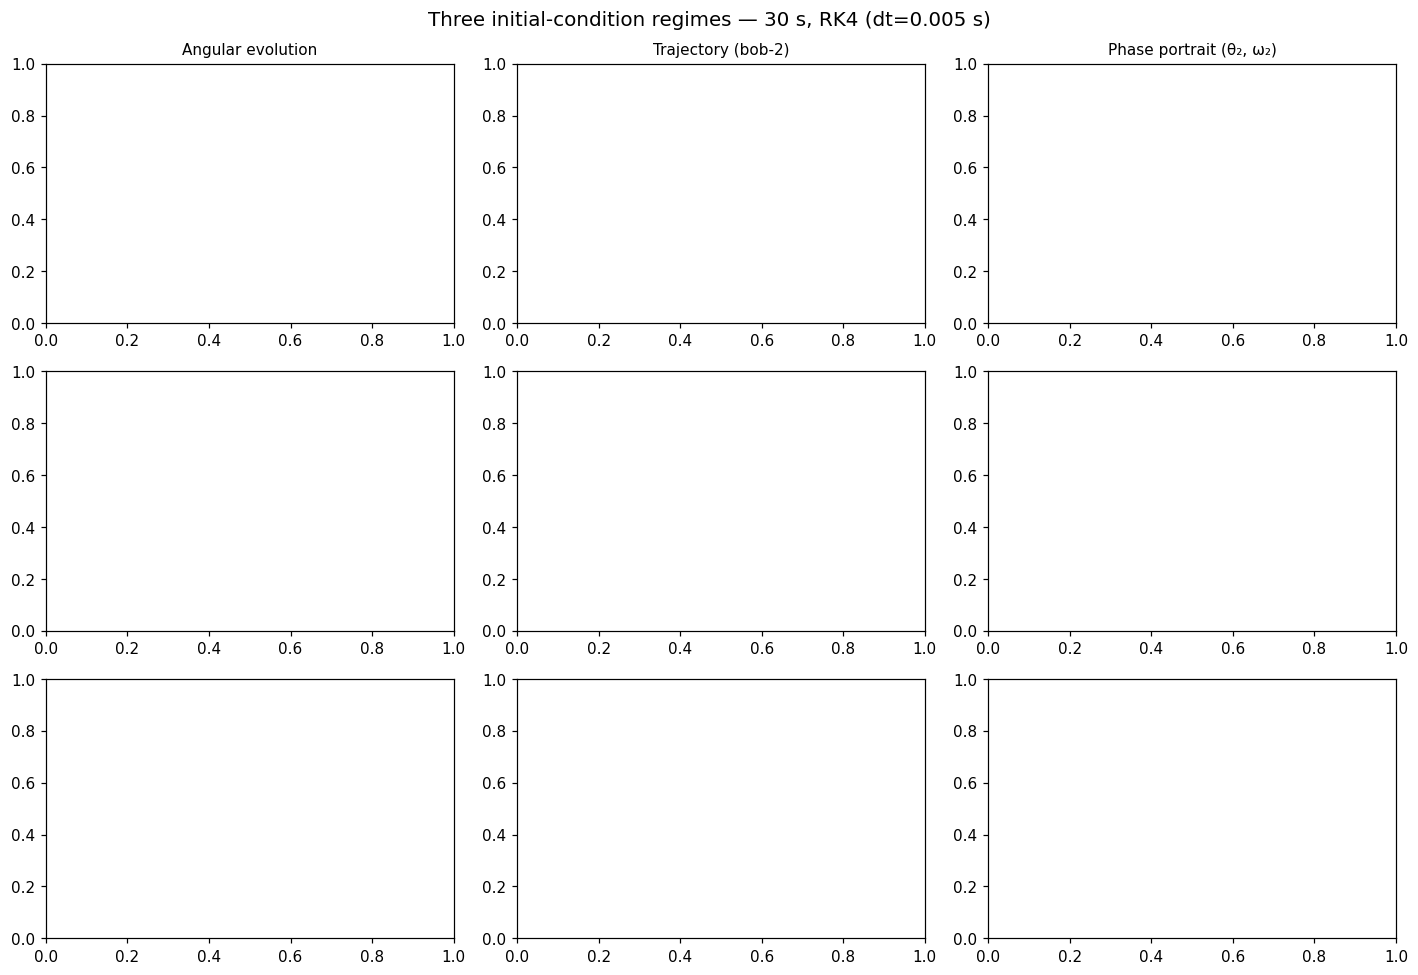

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(13, 9))
fig.suptitle("Three initial-condition regimes \u2014 30 s, RK4 (dt=0.005 s)", fontsize=13)

col_titles = ["Angular evolution", "Trajectory (bob-2)", "Phase portrait (\u03b8\u2082, \u03c9\u2082)"]
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=10)

for i, (c, sol) in enumerate(zip(cases, solutions)):
    color = c["color"]
    t     = sol["t"]

    ax = axes[i, 0]
    ax.plot(t, np.degrees(sol["theta1"]), lw=0.7, color=color, label="\u03b8\u2081")
    ax.plot(t, np.degrees(sol["theta2"]), lw=0.7, color=color, ls="--", alpha=0.7, label="\u03b8\u2082")
    ax.set_ylabel(f"{c['label']}\nangle [\u00b0]", fontsize=8)
    ax.legend(fontsize=7, loc="upper right")
    ax.grid(True, alpha=0.25)

    ax = axes[i, 1]
    ax.plot(sol["x2"], sol["y2"], lw=0.4, color=color, alpha=0.6)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.25)

    ax = axes[i, 2]
    ax.plot(sol["theta2"], sol["omega2"], lw=0.3, color=color, alpha=0.7)
    ax.set_xlabel("\u03b8\u2082 [rad]", fontsize=8)
    ax.set_ylabel("\u03c9\u2082 [rad/s]", fontsize=8)
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig("dp_three_regimes.png", dpi=130, bbox_inches="tight")
plt.show()


## 2. Sensitivity to initial conditions (butterfly effect)

Start two systems at **nearly identical** angles (differing by $\delta\theta_1 = 0.001°$) and watch how their trajectories diverge.  
Exponential divergence is the hallmark of deterministic chaos — Lyapunov exponent $\lambda > 0$.

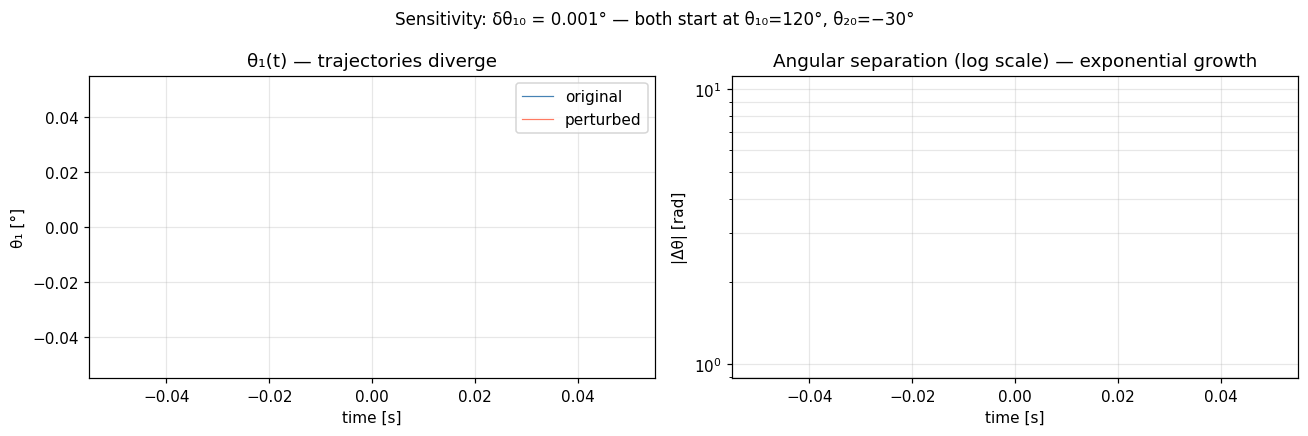

In [6]:
sol_a = load("sensitivity_a.csv")
sol_b = load("sensitivity_b.csv")

sep = np.sqrt(
    (sol_a["theta1"] - sol_b["theta1"])**2 +
    (sol_a["theta2"] - sol_b["theta2"])**2
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(
    "Sensitivity: \u03b4\u03b8\u2081\u2080 = 0.001\u00b0 \u2014 both start at \u03b8\u2081\u2080=120\u00b0, \u03b8\u2082\u2080=\u221230\u00b0",
    fontsize=11,
)

ax = axes[0]
ax.plot(sol_a["t"], np.degrees(sol_a["theta1"]), lw=0.8, color="steelblue", label="original")
ax.plot(sol_b["t"], np.degrees(sol_b["theta1"]), lw=0.8, color="tomato",    label="perturbed", alpha=0.85)
ax.set_xlabel("time [s]")
ax.set_ylabel("\u03b8\u2081 [\u00b0]")
ax.set_title("\u03b8\u2081(t) \u2014 trajectories diverge")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
mask = sep > 0
ax.semilogy(sol_a["t"][mask], sep[mask], lw=0.8, color="purple")
ax.set_xlabel("time [s]")
ax.set_ylabel("|\u0394\u03b8| [rad]")
ax.set_title("Angular separation (log scale) \u2014 exponential growth")
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.savefig("dp_sensitivity.png", dpi=130, bbox_inches="tight")
plt.show()


## 3. Varying mass ratio  $m_2 / m_1$

Fix $\theta_1^0 = 90°$, $\theta_2^0 = 0°$ and vary how heavy bob-2 is relative to bob-1.  
A heavier bob-2 damps the chaotic freedom of the upper arm.

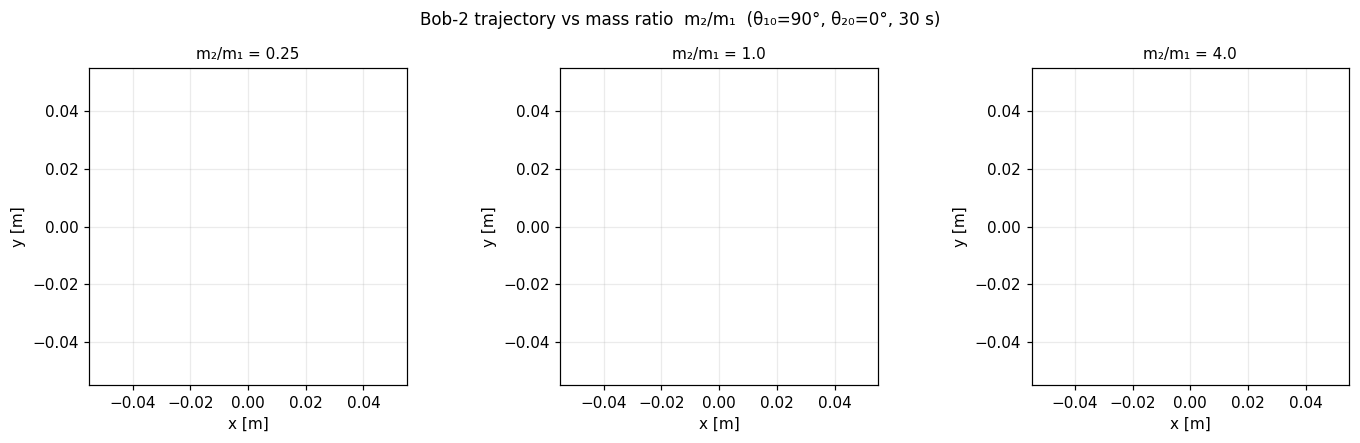

In [7]:
mass_ratios = [
    (0.25, "mass_ratio_0.25.csv", "orchid"),
    (1.00, "mass_ratio_1.00.csv", "seagreen"),
    (4.00, "mass_ratio_4.00.csv", "saddlebrown"),
]

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.suptitle(
    "Bob-2 trajectory vs mass ratio  m\u2082/m\u2081  (\u03b8\u2081\u2080=90\u00b0, \u03b8\u2082\u2080=0\u00b0, 30 s)",
    fontsize=11,
)

for ax, (ratio, fname, col) in zip(axes, mass_ratios):
    sol = load(fname)
    ax.plot(sol["x2"], sol["y2"], lw=0.4, color=col, alpha=0.7)
    ax.set_title(f"m\u2082/m\u2081 = {ratio}", fontsize=10)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig("dp_mass_ratio.png", dpi=130, bbox_inches="tight")
plt.show()


## 4. Energy conservation summary

The RK4 integrator (fixed dt = 0.005 s) conserves total energy $E = T + V$ for all cases above.

/tmp/ipykernel_3258/3767764537.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


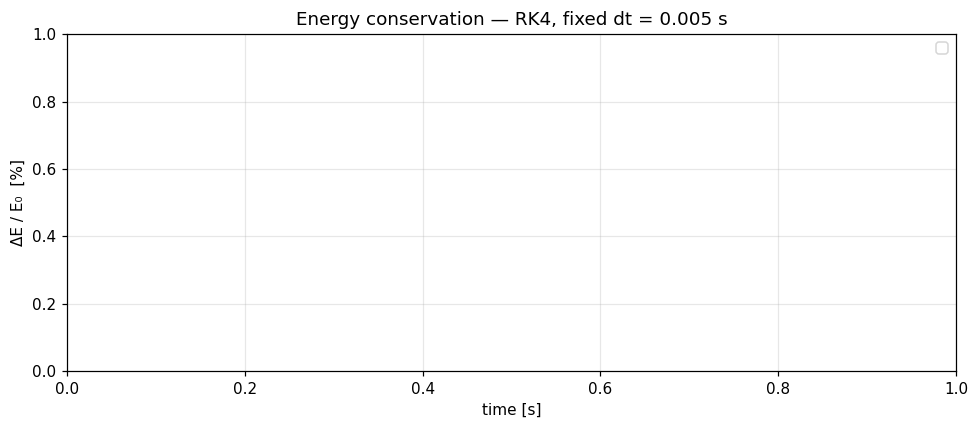

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))

for c, sol in zip(cases, solutions):
    E  = sol["energy"]
    dE = (E - E[0]) / abs(E[0]) * 100
    ax.plot(sol["t"], dE, lw=0.7, label=c["label"], color=c["color"])

ax.axhline(0, color="black", lw=0.5, ls="--")
ax.set_xlabel("time [s]")
ax.set_ylabel("\u0394E / E\u2080  [%]")
ax.set_title("Energy conservation \u2014 RK4, fixed dt = 0.005 s")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("dp_energy_conservation.png", dpi=130, bbox_inches="tight")
plt.show()
